In [1]:
""" Try estimating MLD from near-inertial current (bandpass) 
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from mystats import bandpass_sos, movingavg
from convert_time import datetime_to_yearday

In [2]:
### Info of SD-1042's merged adcp data
year = '2023'
platf_num = '1042'
path_cur_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
tlim_plot = [datetime.datetime(int(year),10,19), datetime.datetime(int(year),11,15,12)] ### 2023 SD1042
nt_plot = int((tlim_plot[1]-tlim_plot[0]).days)
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
print(tticks_label)
### Load adcp data
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
_, yday_cur_SD = datetime_to_yearday( dtime_cur_SD )
print(ds_cur_SD)
vars_str = ['longitude','latitude','vel_east','vel_north','depth','data_flag']
for i in range( len(vars_str) ):
    temp = ds_cur_SD.variables[vars_str[i]][:]
    temp.filled(np.nan)
    exec( vars_str[i]+' = temp')
del time
iOK_vel = (data_flag !=0)
vel_east[iOK_vel] = np.nan
vel_north[iOK_vel] = np.nan

['10/19', '10/20', '10/21', '10/22', '10/23', '10/24', '10/25', '10/26', '10/27', '10/28', '10/29', '10/30', '10/31', '11/01', '11/02', '11/03', '11/04', '11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11', '11/12', '11/13', '11/14']
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1042
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(6154), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, depth), float64 error

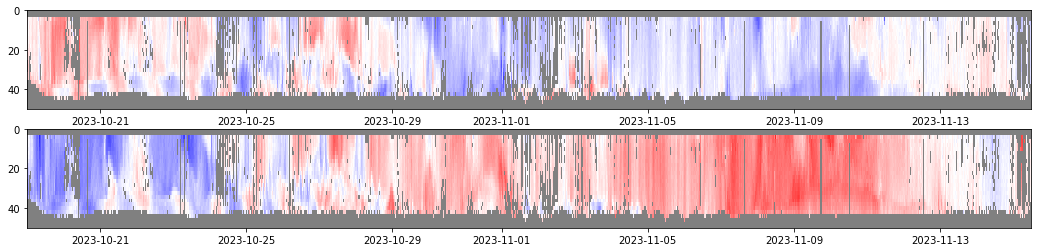

In [3]:
### load tidal data
path_tide = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_SD_uv_tide/'
fn_tide = 'timeseries_uv-tide_'+year+'-SD'+platf_num+'.txt'
data_tide = np.genfromtxt(path_tide+fn_tide)
### de-tide
vel_east_detide = np.nan*np.ones( vel_east.shape )
vel_north_detide = vel_east_detide.copy()
for z in range( len(depth) ):
    vel_east_detide[:,z] = 100*vel_east[:,z]-data_tide[:,4]
    vel_north_detide[:,z] = 100*vel_north[:,z]-data_tide[:,5]
### plot detide velocity
varnms_plot = ['vel_east_detide','vel_north_detide']
plt.clf()
plt.gcf().set_size_inches(18, 4)
for i, varnm in enumerate( varnms_plot ):
    plt.subplot(2,1,i+1)
    plt.pcolormesh(dtime_cur_SD, depth, eval(varnm).transpose(), cmap='bwr',vmin=-40,vmax=40, shading='nearest')
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot)
    plt.gca().set_facecolor('gray')

In [4]:
### interpolate velocity in time because of irregular time grids & missing/flagged data
nt = int((tlim_plot[1]-tlim_plot[0]).total_seconds()/60/15)
dtime_cur_SD_intp = np.array([tlim_plot[0]+datetime.timedelta(minutes=i*15) for i in range(nt)])
timestamp_cur_SD_intp = np.array([dtime_cur_SD_intp[i].timestamp() for i in range(len(dtime_cur_SD_intp))])

vel_east_detide_intp = np.nan*np.ones( (len(dtime_cur_SD_intp), len(depth)))
vel_north_detide_intp = vel_east_detide_intp.copy()
for z in range( len(depth) ):
    iok = ~np.isnan( vel_east_detide[:,z])
    if np.sum(iok) > 2:
        t0 = timestamp_cur_SD[iok][0]
        t1 = timestamp_cur_SD[iok][-1]
        it0_intp = np.where( timestamp_cur_SD_intp>= t0 )[0][0]
        it1_intp = np.where( timestamp_cur_SD_intp<= t1 )[0][-1]
        vel_east_detide_intp[it0_intp:it1_intp+1,z] = np.interp( timestamp_cur_SD_intp[it0_intp:it1_intp+1], timestamp_cur_SD[iok], vel_east_detide[iok,z])
        vel_north_detide_intp[it0_intp:it1_intp+1,z] = np.interp( timestamp_cur_SD_intp[it0_intp:it1_intp+1], timestamp_cur_SD[iok], vel_north_detide[iok,z])

f_SD =6.72E-05. T_inertial =25.99hr
T_NI(equivalent to 0.80f~1.20f) =32.49hr~21.66hr


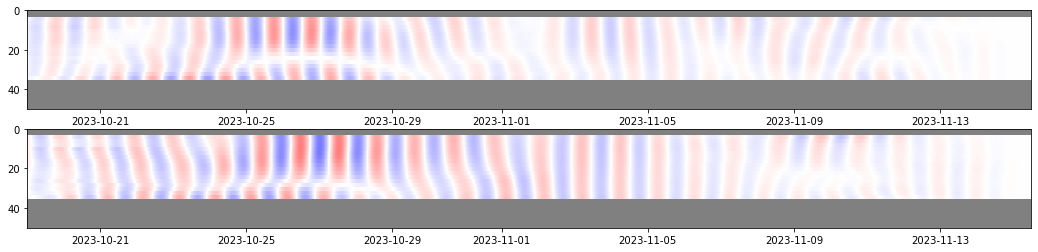

In [5]:
### band pass current (detide) velocity to NI band
f_SD = 2*(2*np.pi/86400)*np.sin(np.mean(latitude)/180*np.pi) # 1/s
n_f = np.array([0.8,1.2]) #[0.8,1.2]
f_bp = f_SD*n_f
T_inertial = 2*np.pi/f_SD/3600 # hr
print('f_SD ={:.2E}. T_inertial ={:.2f}hr'.format(f_SD, T_inertial))
print('T_NI(equivalent to {:.2f}f~{:.2f}f) ={:.2f}hr~{:.2f}hr'.format(n_f[0],n_f[1],T_inertial/n_f[0],T_inertial/n_f[1]))

u_detide_bp = np.nan*np.ones( vel_east_detide_intp.shape )
v_detide_bp = u_detide_bp.copy()
###
dsec_data = (dtime_cur_SD_intp[1]-dtime_cur_SD_intp[0]).total_seconds()
bp_sec = 2*np.pi/f_bp
for z in range( len(depth) ):
    u_detide_bp[:,z] = bandpass_sos(vel_east_detide_intp[:,z], dsec_data, bp_sec[0], bp_sec[1], 2)
    v_detide_bp[:,z] = bandpass_sos(vel_north_detide_intp[:,z], dsec_data, bp_sec[0], bp_sec[1], 2)

### plot bandpass velocity
varnms_plot = ['u_detide_bp','v_detide_bp']
plt.clf()
plt.gcf().set_size_inches(18, 4)
for i, varnm in enumerate( varnms_plot ):
    plt.subplot(2,1,i+1)
    plt.pcolormesh(dtime_cur_SD_intp, depth, eval(varnm).transpose(), cmap='bwr',vmin=-20,vmax=20, shading='nearest')
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot)
    plt.gca().set_facecolor('gray')

<Figure size 432x288 with 0 Axes>

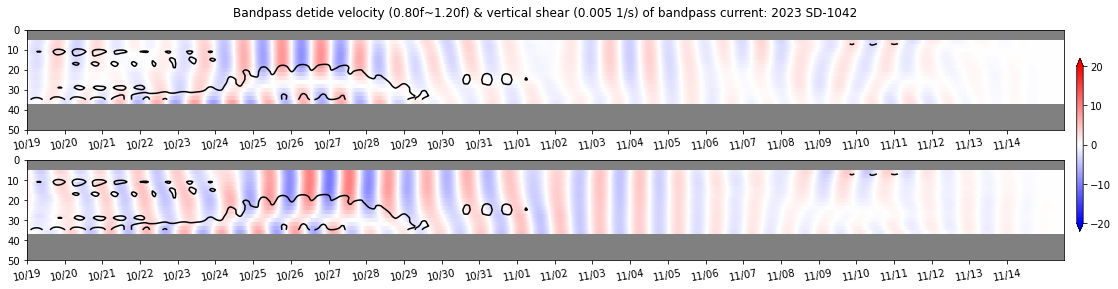

In [6]:
### compute shear of the NI currents
z_fix = 6-depth[0]
depth = depth+z_fix
depth_s = 0.5*(depth[:-1]+depth[1:])
# print(depth_s)
u_s = np.divide( 0.01*np.subtract( u_detide_bp[:,:-1],u_detide_bp[:,1:]),np.subtract(depth[:-1], depth[1:]) )
v_s = np.divide( 0.01*np.subtract( v_detide_bp[:,:-1],v_detide_bp[:,1:]),np.subtract(depth[:-1], depth[1:]) )
vel_bp_shear_sq = np.sqrt( np.square(u_s) + np.square(v_s) )
lev_shear = 0.005 # s^-1
### plot shear over bandpass velocity
varnms_plot = ['u_detide_bp','v_detide_bp']
plt.clf()
fig = plt.figure(figsize=(18,4))
for i, varnm in enumerate( varnms_plot ):
    plt.subplot(2,1,i+1)
    cs = plt.pcolormesh(dtime_cur_SD_intp, depth, eval(varnm).transpose(), cmap='bwr',vmin=-20,vmax=20, shading='nearest')
    plt.contour(dtime_cur_SD_intp, depth_s, vel_bp_shear_sq.transpose(), colors=['k'],levels=[lev_shear])
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot)
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=10)
    plt.gca().set_facecolor('gray')
cbar_ax = fig.add_axes([.91,.2,.005,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
###
plt.suptitle('Bandpass detide velocity ({:.2f}f~{:.2f}f) & vertical shear ({:.3f} 1/s) of bandpass current: '.format(n_f[0],n_f[1],lev_shear)\
             +year+' SD-'+platf_num)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.3)
### save to figure
plt.savefig('time-depth_uv-detide-bp({:.2f}f-{:.2f}f)_shear({:.3f})_'.format(n_f[0],n_f[1],lev_shear)+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

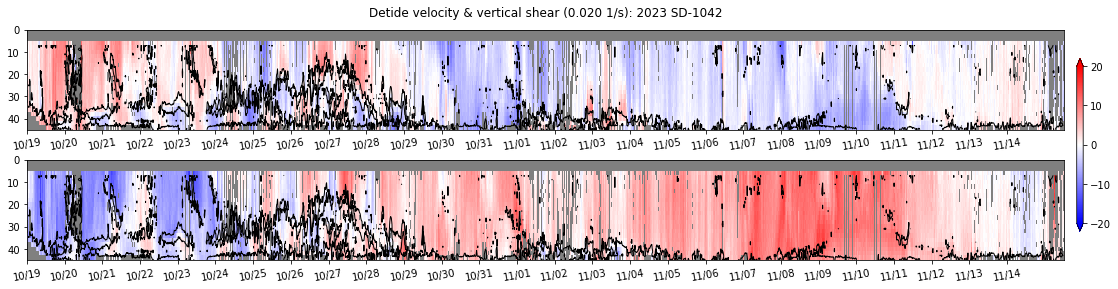

In [8]:
### compute vertical shear shear
u_s = np.divide( 0.01*np.subtract( vel_east_detide_intp[:,:-1],vel_east_detide_intp[:,1:]),np.subtract(depth[:-1], depth[1:]) )
v_s = np.divide( 0.01*np.subtract( vel_north_detide_intp[:,:-1],vel_north_detide_intp[:,1:]),np.subtract(depth[:-1], depth[1:]) )
vel_shear_sq = np.sqrt( np.square(u_s) + np.square(v_s) )
lev_shear = 0.02 # s^-1
### plot shear over detide velocity
varnms_plot = ['vel_east_detide','vel_north_detide']
plt.clf()
fig = plt.figure(figsize=(18,4))
for i, varnm in enumerate( varnms_plot ):
    plt.subplot(2,1,i+1)
    plt.pcolormesh(dtime_cur_SD, depth, eval(varnm).transpose(), cmap='bwr',vmin=-40,vmax=40, shading='nearest')
    plt.contour(dtime_cur_SD_intp, depth_s, vel_shear_sq.transpose(), colors=['k'],levels=[lev_shear], linewidths=1)
    plt.ylim([0,45])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot)
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=10)
    plt.gca().set_facecolor('gray')
cbar_ax = fig.add_axes([.91,.2,.005,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')

###
plt.suptitle('Detide velocity & vertical shear ({:.3f} 1/s): '.format(lev_shear)\
             +year+' SD-'+platf_num)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.3)
### save to figure
plt.savefig('time-depth_uv-detide_shear({:.3f})_'.format(lev_shear)+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [ ]:
### check if each profile reach the lev_shear accordingly
lev_shear = [0.02, 0.005]
varnms_plot = ['vel_shear_sq','vel_bp_shear_sq'] 
### compute MLD based on shear-sqared criteria
depth_mld_shear_cri = np.nan*np.ones( (len(dtime_cur_SD_intp),len(lev_shear)) )
for v, varnm in enumerate(varnms_plot):
    for i in range( len(dtime_cur_SD_intp) ):
        var_plot = eval(varnm)
        ilg_shear_cri = np.where( var_plot[i,:]> lev_shear[v]  )[0]
        if len(ilg_shear_cri)> 0:
            depth_mld_shear_cri[i,v] = depth_s[ilg_shear_cri][0]
        else:
            ### the deepest available data
            ideep_notnan = np.where( ~np.isnan( var_plot[i,:]) )[0][-1]
            depth_mld_shear_cri[i,v] = depth_s[ideep_notnan]

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_42262/2377566634.py:10: RuntimeWarning: divide by zero encountered in log10
  cs = plt.pcolormesh(dtime_cur_SD_intp, depth_s, np.log10(var_plot).transpose(), cmap='YlGnBu_r',vmin=-3,vmax=-0.5, shading='nearest')
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_42262/2377566634.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(dtime_cur_SD_intp, depth_s, var_plot.transpose(), colors=['k'],levels=[lev_shear[i]],linewidths=1,label='shear sq={:.E}')


<Figure size 432x288 with 0 Axes>

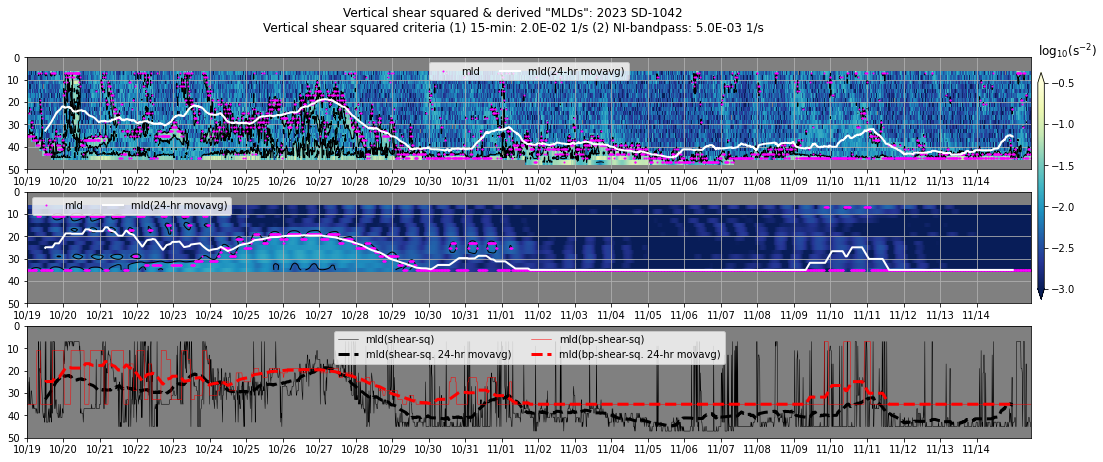

In [ ]:
### plot shear squared
varnms_plot = ['vel_shear_sq','vel_bp_shear_sq'] 
lev_shear = [0.02, 0.005]
nrow = len(varnms_plot)+1
plt.clf()
fig = plt.figure(figsize=(18,7))
for i, varnm in enumerate( varnms_plot ):
    plt.subplot(nrow,1,i+1)
    var_plot = eval(varnm)
    cs = plt.pcolormesh(dtime_cur_SD_intp, depth_s, np.log10(var_plot).transpose(), cmap='YlGnBu_r',vmin=-3,vmax=-0.5, shading='nearest')
    plt.contour(dtime_cur_SD_intp, depth_s, var_plot.transpose(), colors=['k'],levels=[lev_shear[i]],linewidths=1,label='shear sq={:.E}')
    ### plot MLD by shear criteria
    plt.plot(dtime_cur_SD_intp, depth_mld_shear_cri[:,i],'.',ms=2,color='magenta',label='mld')
    mld_mov_avg = movingavg(depth_mld_shear_cri[:,i],24*4,12*4)
    plt.plot(dtime_cur_SD_intp, mld_mov_avg, color='white',lw=2,label='mld(24-hr movavg)')
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot)
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=0)
    plt.gca().set_facecolor('gray')
    plt.grid()
    plt.legend(loc='best',ncol=3)
cbar_ax = fig.add_axes([.905,.4,.005,.45])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
cbar_ax.set_title('log$_{10}$(s$^{-2}$)',y=1.1,loc='left')

### add MLD
str_app = ['shear-sq','bp-shear-sq']
col_mld = ['black','red']
plt.subplot(nrow,1,nrow)
for i in range( depth_mld_shear_cri.shape[1] ):
    plt.plot(dtime_cur_SD_intp, depth_mld_shear_cri[:,i],color=col_mld[i],lw=0.5,label='mld('+str_app[i]+')')
    mld_mov_avg = movingavg(depth_mld_shear_cri[:,i],24*4,12*4)
    plt.plot(dtime_cur_SD_intp, mld_mov_avg, '--',color=col_mld[i],lw=3,label='mld('+str_app[i]+'. 24-hr movavg)')
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.xlim(tlim_plot)
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=0)
    plt.gca().set_facecolor('gray')
    plt.grid()
plt.legend(loc='best',ncol=2)
plt.suptitle('Vertical shear squared & derived "MLDs": '+year+' SD-'+platf_num+\
             '\nVertical shear squared criteria (1) 15-min: {:.1E} 1/s (2) NI-bandpass: {:.1E} 1/s'.format(lev_shear[0],lev_shear[1]))

### save to figure
plt.savefig('time-depth_shear-sq(raw{:.1E}_bp{:.1E})_MLD(by-shear-sq-crit)_'.format(lev_shear[0],lev_shear[1])\
            +year+'-SD'+platf_num+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')